# Base Client: Mean Speed Profile

# Libraries and Data

### Libraries

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from stare import Inference
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
pip install statsmodels


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Data

In [3]:
df100 = pd.read_excel('public_100.xlsx')
df100.head()

,Nom PCE,duree pret(j),distance pret(km),distance annuelle(km),duree roulage(h),Vmoy,Vmax,Amoy,%tps sup seuil vitesse,Temps puissance sup seuil 1 (s),Temps puissance sup seuil 2 (s),Nb trajets,% trajets non roulants,distance ville annuelle,distance route annuelle,distance autoroute annuelle,cluster
0,66122_B73_V4Y_711_Client_14_24Hz_to_5Hz,13.132963,539.302664,14988.656619,11.344056,47.540543,177.128174,0.666193,0.047994,91.801270,0.799316,38,0.000000,4179.786427,8338.924468,2469.945613,0
1,66122_B73_V4Y_711_Client_07_5Hz_to_5Hz,12.658021,1282.316504,36976.201110,26.396555,48.578930,143.415863,0.307747,0.000000,9.203125,0.000000,59,0.000000,7155.707495,10819.347977,19001.142997,1
2,66122_B73_V4Y_711_Client_06_5Hz_to_5Hz,14.718657,316.131248,7839.567308,16.170274,19.550146,87.626518,0.459828,0.000000,0.200195,0.000000,79,2.531646,7775.472662,64.094858,0.000000,2
3,66122_B73_V4Y_711_Client_03_5Hz_to_5Hz,13.616065,894.806208,23986.685616,22.012109,40.650631,128.613525,0.285401,0.000000,0.000000,0.000000,67,2.985075,6619.990087,5851.175067,11515.519755,1
4,66122_B73_P9X_701_Client_22_24Hz_to_5Hz,21.358657,1415.352209,24187.080035,34.552671,40.962177,151.340195,0.415672,0.000000,0.000000,0.000000,90,1.111111,4120.040965,14424.422616,5642.616604,0


In [4]:
NCBS = pd.read_excel('NCBS.xlsx')
NCBS.head()

,V,R,A
0,60,10,30
1,20,70,10
2,20,60,20
3,15,20,65
4,10,25,65


# 100 clients
#### Clustered Clients

## Data enrichment

Creating the same features (ratio) that are informed on NCBS data

In [5]:
df100['VMED'] = df100['distance pret(km)'] / df100['duree roulage(h)']
df100['Diff Perc'] = ((df100['Vmoy'] - df100['VMED']).abs() / df100['VMED']) * 100
df100['Diff Perc'] = df100['Diff Perc'].round(2)
df100['V %'] = (df100['distance ville annuelle']/ (df100['distance annuelle(km)'])) *100
df100['R %'] = (df100['distance route annuelle']/ (df100['distance annuelle(km)'])) *100
df100['A %'] = (df100['distance autoroute annuelle']/ (df100['distance annuelle(km)'])) *100
df100['V %'] = df100['V %'].round(2)
df100['R %'] = df100['R %'].round(2)
df100['A %'] = df100['A %'].round(2)
df100.head()

,Nom PCE,duree pret(j),distance pret(km),distance annuelle(km),duree roulage(h),Vmoy,Vmax,Amoy,%tps sup seuil vitesse,Temps puissance sup seuil 1 (s),...,% trajets non roulants,distance ville annuelle,distance route annuelle,distance autoroute annuelle,cluster,VMED,Diff Perc,V %,R %,A %
0,66122_B73_V4Y_711_Client_14_24Hz_to_5Hz,13.132963,539.302664,14988.656619,11.344056,47.540543,177.128174,0.666193,0.047994,91.801270,...,0.000000,4179.786427,8338.924468,2469.945613,0,47.540549,0.0,27.89,55.63,16.48
1,66122_B73_V4Y_711_Client_07_5Hz_to_5Hz,12.658021,1282.316504,36976.201110,26.396555,48.578930,143.415863,0.307747,0.000000,9.203125,...,0.000000,7155.707495,10819.347977,19001.142997,1,48.578934,0.0,19.35,29.26,51.39
2,66122_B73_V4Y_711_Client_06_5Hz_to_5Hz,14.718657,316.131248,7839.567308,16.170274,19.550146,87.626518,0.459828,0.000000,0.200195,...,2.531646,7775.472662,64.094858,0.000000,2,19.550148,0.0,99.18,0.82,0.00
3,66122_B73_V4Y_711_Client_03_5Hz_to_5Hz,13.616065,894.806208,23986.685616,22.012109,40.650631,128.613525,0.285401,0.000000,0.000000,...,2.985075,6619.990087,5851.175067,11515.519755,1,40.650636,0.0,27.60,24.39,48.01
4,66122_B73_P9X_701_Client_22_24Hz_to_5Hz,21.358657,1415.352209,24187.080035,34.552671,40.962177,151.340195,0.415672,0.000000,0.000000,...,1.111111,4120.040965,14424.422616,5642.616604,0,40.962165,0.0,17.03,59.64,23.33


In [6]:
df100[['V %','R %', 'A %']].describe()

,V %,R %,A %
count,100.000000,100.000000,100.00000
mean,34.864200,37.020600,24.82190
std,22.454433,19.132537,24.41509
min,2.350000,0.820000,0.00000
25%,17.187500,23.385000,4.72000
50%,28.415000,33.340000,16.39500
75%,50.475000,51.185000,39.30750
max,99.180000,82.870000,88.10000


Selecting just the interested columns

In [7]:
df100VRA = df100.iloc[:, [5] + list(range(-3, 0))]
df100VRA.columns = ['Vmoy','x_V', 'x_R', 'x_A']
df100VRA.head()

,Vmoy,x_V,x_R,x_A
0,47.540543,27.89,55.63,16.48
1,48.578930,19.35,29.26,51.39
2,19.550146,99.18,0.82,0.00
3,40.650631,27.60,24.39,48.01
4,40.962177,17.03,59.64,23.33


Testing the CI just for the 100 clients

Confidence Intervals for Vmoy:
1th Percentile: 7.62 to 11.21
25th Percentile: 18.66 to 25.38
50th Percentile: 27.99 to 33.93
75th Percentile: 36.72 to 48.66
95th Percentile: 53.02 to 63.86
99th Percentile: 60.82 to 69.99


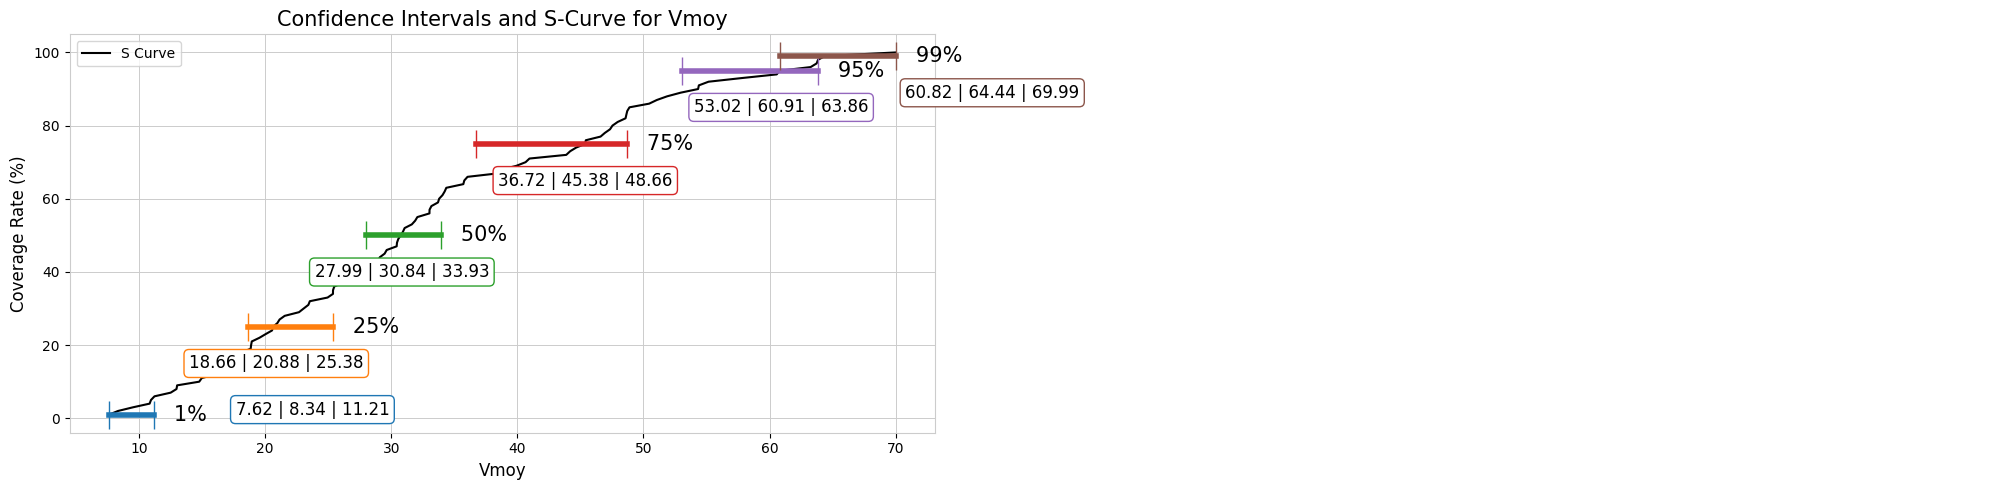

In [116]:
# Simplified functions
def calculate_cdf(data):
    sorted_data = np.sort(data)
    return sorted_data, [percentileofscore(sorted_data, value) for value in sorted_data]

def bootstrap_confidence_interval(data, percentiles=(1, 25, 50, 75, 95, 99), confidence=0.95, n_bootstraps=1000):
    bootstraps = [np.percentile(np.random.choice(data, size=len(data), replace=True), percentiles) for _ in range(n_bootstraps)]
    return {p: (np.percentile(bootstraps, (1-confidence)/2*100, axis=0)[i], 
                np.percentile(bootstraps, (1+confidence)/2*100, axis=0)[i]) for i, p in enumerate(percentiles)}

def plot_confidence_intervals(df, column=None, percentiles=[1, 25, 50, 75, 95, 99], confidence=0.95, n_bootstraps=1000):
    if column:
        # Plot for a single column
        columns = [column]
    else:
        # Plot for all columns
        columns = df.columns
    
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axs = axs.flatten()

    for i, col in enumerate(columns):
        data = df[col].dropna()  # Ensure data does not have NaN values
        sorted_data, cdf = calculate_cdf(data)
        intervals = bootstrap_confidence_interval(data, percentiles, confidence, n_bootstraps)
        
        # Print confidence intervals
        print(f"Confidence Intervals for {col}:")
        for p in percentiles:
            interval = intervals[p]
            print(f"{p}th Percentile: {interval[0]:.2f} to {interval[1]:.2f}")
        
        ax = axs[i]
        
        # S-curve plot
        ax.plot(sorted_data, cdf, color='k', label='S Curve')
        
        # Confidence intervals and percentiles
        for j, p in enumerate(percentiles):
            interval = intervals[p]
            percentile_value = np.percentile(data, p)
            ax.plot(interval, [p, p], '|-', markersize=20, color=f'C{j}', linewidth=4)

            # Determine position of the annotation text
            if p == 1:
                xytext = (140, 0)  # Higher offset for low percentiles
            elif p == 99:
                xytext = (120, -30)  # Lower offset for high percentiles
            else:
                xytext = (0, -30)  # Default offset for other percentiles

            ax.text(interval[1], p, f'   {p}% ', fontsize=15, verticalalignment='center')
            ax.annotate(f'{interval[0]:.2f} | {percentile_value:.2f} | {interval[1]:.2f}', 
                        (percentile_value, p), textcoords="offset points", xytext=xytext, ha='center', 
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor=f'C{j}', facecolor="white"))

        # Axis limits, labels, and titles
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Coverage Rate (%)', fontsize=12)
        ax.set_title(f'Confidence Intervals and S-Curve for {col}', fontsize=15)
        ax.legend(loc='best', fontsize=10)

        # Set grid and axis line color
        grid_color = '.8'
        ax.grid(True, color=grid_color, linestyle='-', linewidth=0.7)
        ax.spines['bottom'].set_color(grid_color)
        ax.spines['top'].set_color(grid_color)
        ax.spines['right'].set_color(grid_color)
        ax.spines['left'].set_color(grid_color)
        ax.tick_params(axis='both', colors='black', labelsize=10)

    # Turn off unused subplots
    for i in range(len(columns), len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot for a single column
plot_confidence_intervals(df100VRA, 'Vmoy', percentiles=[1, 25, 50, 75, 95, 99])


Adjusting the layout to be the same as the NCBS data

In [8]:
columns = df100VRA.columns.tolist()
first_col = columns.pop(0)
columns.append(first_col)
df100VRA = df100VRA[columns]

## Data Analysis

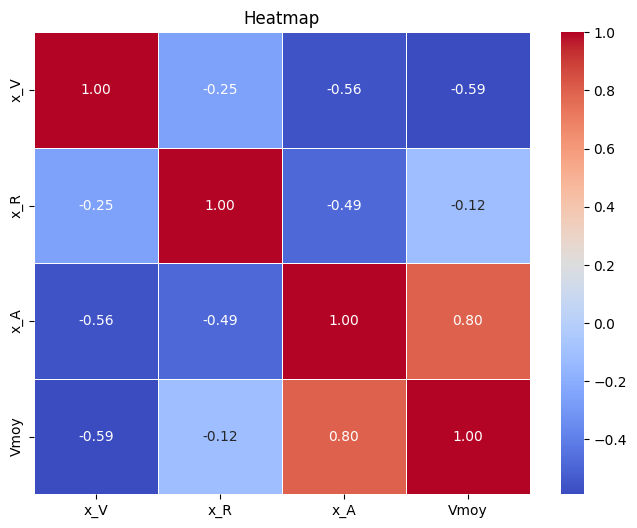

In [9]:
# Calculate the correlation matrix
correlation_matrix = df100VRA.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap')
plt.show()

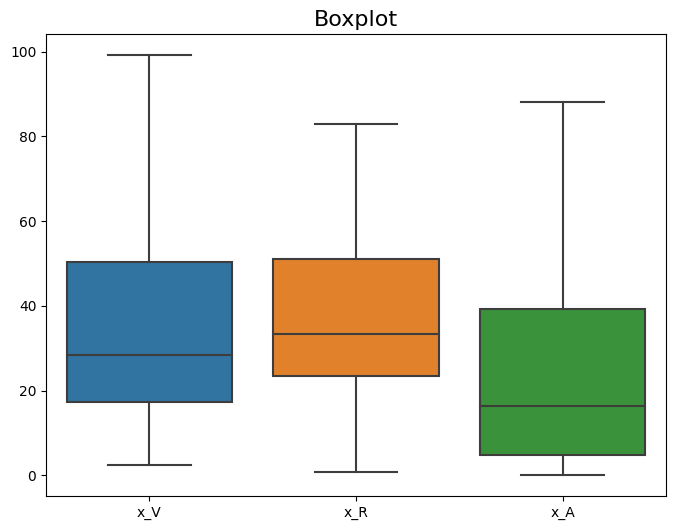

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df100VRA.iloc[:, :3])  # Seleciona apenas as três primeiras colunas
plt.title("Boxplot", fontsize=16)
plt.show()

## Regression Models

Train and Test Split with the 100 clients database

In [11]:
X = df100VRA[['x_V', 'x_R', 'x_A']]
y = df100VRA['Vmoy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#X_train_scaled = X_train
#X_test_scaled = X_test

Standarization

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(X_train_scaled.head())
print(X_test_scaled.head())

        x_V       x_R       x_A
0  0.037163  1.027009 -0.680782
1 -0.386051  1.342659 -0.530588
2  0.825581 -1.216079  0.299326
3 -0.214656  1.293156 -0.650824
4  0.802289  0.349398 -0.869841
        x_V       x_R       x_A
0 -0.414178  1.486911 -0.614389
1 -1.502757 -1.116008 -0.169474
2  1.881639 -0.893509 -0.918826
3  1.027300 -1.546634  0.365314
4 -1.054493 -0.335132  1.361210


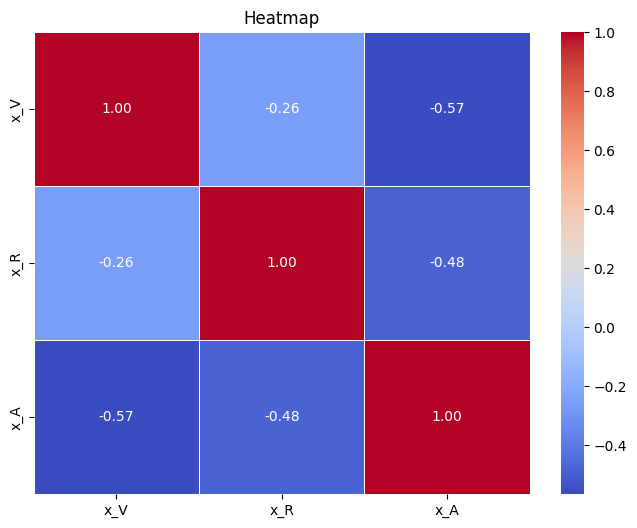

In [15]:
# Calculate the correlation matrix
correlation_matrix = X_train_scaled.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap')
plt.show()

In [61]:
# Assuming X and y are already defined as your input features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of regression models to test
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Machine (SVM)": SVR(),
    "XGBoost": XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
}

# List to store results
results_list = []

# Loop through regression models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predictions for training and test sets
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics for training set
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Calculate metrics for test set
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Cross-validation for MSE
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    # Append results to the list
    results_list.append({
        "Model": model_name,
        "MSE Train": mse_train,
        "MAE Train": mae_train,
        "R2 Train": r2_train,
        "MSE Test": mse_test,
        "MAE Test": mae_test,
        "R2 Test": r2_test,
        "CV MSE": cv_mse
    })

# Define the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.01)))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dense(1))

# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse_list = []

for train_index, val_index in kf.split(X_train_scaled):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    nn_model.fit(X_train_cv, y_train_cv, validation_data=(X_val_cv, y_val_cv),
                 epochs=200, batch_size=4, callbacks=[early_stopping], verbose=0)
    
    # Evaluate on the validation set
    y_val_pred = nn_model.predict(X_val_cv).flatten()
    cv_mse = mean_squared_error(y_val_cv, y_val_pred)
    cv_mse_list.append(cv_mse)

# Calculate mean cross-validated MSE
mean_cv_mse = np.mean(cv_mse_list)

# Predictions and model evaluation for the neural network
y_pred_train_nn = nn_model.predict(X_train_scaled).flatten()
y_pred_test_nn = nn_model.predict(X_test_scaled).flatten()

# Calculate metrics for training set
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
mae_train_nn = mean_absolute_error(y_train, y_pred_train_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)

# Calculate metrics for test set
mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
mae_test_nn = mean_absolute_error(y_test, y_pred_test_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)

# Append neural network results to the list
results_list.append({
    "Model": "Neural Network",
    "MSE Train": mse_train_nn,
    "MAE Train": mae_train_nn,
    "R2 Train": r2_train_nn,
    "MSE Test": mse_test_nn,
    "MAE Test": mae_test_nn,
    "R2 Test": r2_test_nn,
    "CV MSE": mean_cv_mse
})

# Convert results list to DataFrame
results = pd.DataFrame(results_list)

# Display the results table
print(results)


1/1 [==============================] - 0s 20ms/step
                          Model   MSE Train  MAE Train  R2 Train    MSE Test  \
0             Linear Regression   58.415817   5.991740  0.736166   62.300677   
1              Ridge Regression   58.624133   6.014842  0.735225   66.435808   
2              Lasso Regression   63.477200   6.340416  0.713306   93.795364   
3                 Decision Tree    0.000000   0.000000  1.000000  119.940141   
4                 Random Forest   12.363647   2.611202  0.944160   79.861798   
5  Support Vector Machine (SVM)  118.299495   8.323630  0.465702  139.610224   
6                       XGBoost    0.000007   0.001948  1.000000   85.901304   
7                Neural Network   54.061021   5.875964  0.755834   60.750705   

   MAE Test   R2 Test      CV MSE  
0  5.946034  0.701285   62.701134  
1  6.153629  0.681458   62.341777  
2  7.693583  0.550276   67.881168  
3  7.486383  0.424919  122.904625  
4  6.405277  0.617084   85.474147  
5  9.770720

In [62]:
results

,Model,MSE Train,MAE Train,R2 Train,MSE Test,MAE Test,R2 Test,CV MSE
0,Linear Regression,58.415817,5.991740,0.736166,62.300677,5.946034,0.701285,62.701134
1,Ridge Regression,58.624133,6.014842,0.735225,66.435808,6.153629,0.681458,62.341777
2,Lasso Regression,63.477200,6.340416,0.713306,93.795364,7.693583,0.550276,67.881168
3,Decision Tree,0.000000,0.000000,1.000000,119.940141,7.486383,0.424919,122.904625
4,Random Forest,12.363647,2.611202,0.944160,79.861798,6.405277,0.617084,85.474147
5,Support Vector Machine (SVM),118.299495,8.323630,0.465702,139.610224,9.770720,0.330606,139.512706
6,XGBoost,0.000007,0.001948,1.000000,85.901304,6.448663,0.588126,88.823858
7,Neural Network,54.061021,5.875964,0.755834,60.750705,6.301091,0.708717,55.634077


# NCBS

In [63]:
NCBS

,V,R,A
0,60,10,30
1,20,70,10
2,20,60,20
3,15,20,65
4,10,25,65
...,...,...,...
2259,30,30,30
2260,65,25,10
2261,20,80,0
2262,50,40,10


Non-parametric:

### V NCBS

In [64]:
from scipy.stats import gaussian_kde

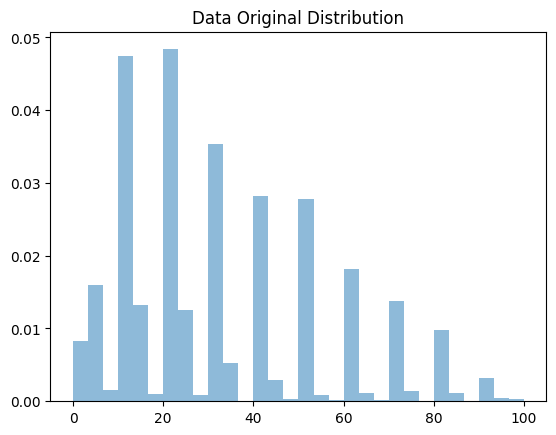

In [85]:
V = NCBS["V"]

plt.hist(V, bins=30, alpha=0.5, density=True)
plt.title("Data Original Distribution")
plt.show()

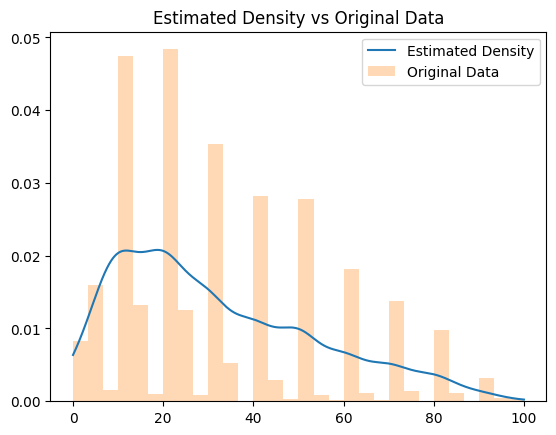

In [86]:
# Estimate density with KDE using Gaussian kernel
kde_V = gaussian_kde(V, bw_method='scott')

# Visualize the estimated density
x_V_vals = np.linspace(min(V), max(V), 3000)
density_V_vals = kde_V(x_V_vals)

plt.plot(x_V_vals, density_V_vals, label='Estimated Density')
plt.hist(V, bins=30, alpha=0.3, density=True, label='Original Data')
plt.title("Estimated Density vs Original Data")
plt.legend()
plt.show()

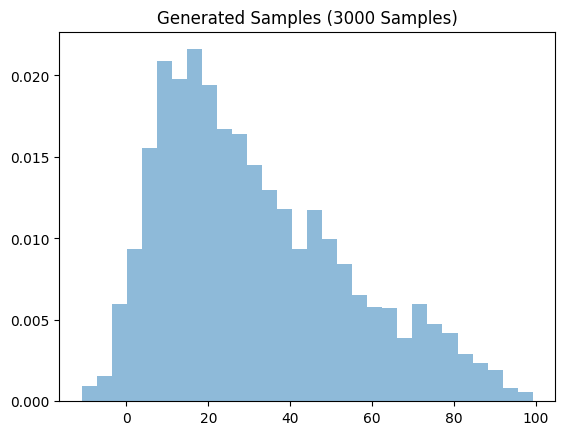

In [87]:
# Generate N samples from the estimated density
N = 3000  # Number of samples to generate
new_samples_V = kde_V.resample(N)

# Visualize the generated samples
plt.hist(new_samples_V.T, bins=30, alpha=0.5, density=True)
plt.title(f"Generated Samples ({N} Samples)")
plt.show()

### R NCBS

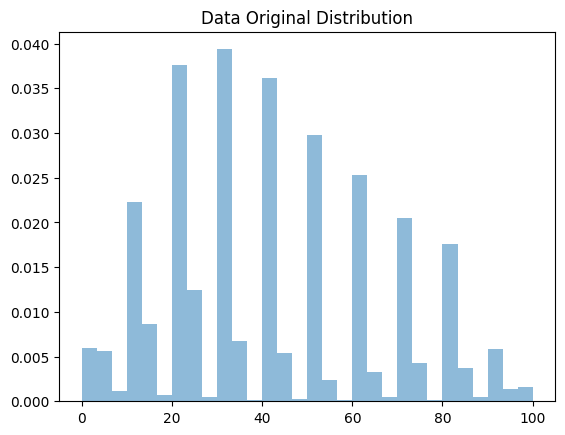

In [88]:
R = NCBS["R"]

plt.hist(R, bins=30, alpha=0.5, density=True)
plt.title("Data Original Distribution")
plt.show()

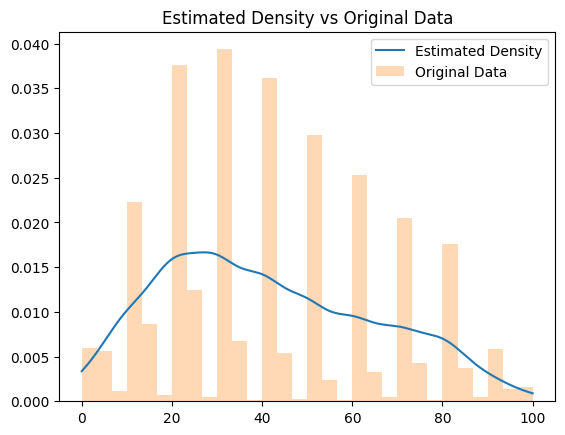

In [89]:
# Estimate density with KDE using Gaussian kernel
kde_R = gaussian_kde(R, bw_method='scott')

# Visualize the estimated density
x_R_vals = np.linspace(min(R), max(R), 3000)
density_R_vals = kde_R(x_R_vals)

plt.plot(x_R_vals, density_R_vals, label='Estimated Density')
plt.hist(R, bins=30, alpha=0.3, density=True, label='Original Data')
plt.title("Estimated Density vs Original Data")
plt.legend()
plt.show()

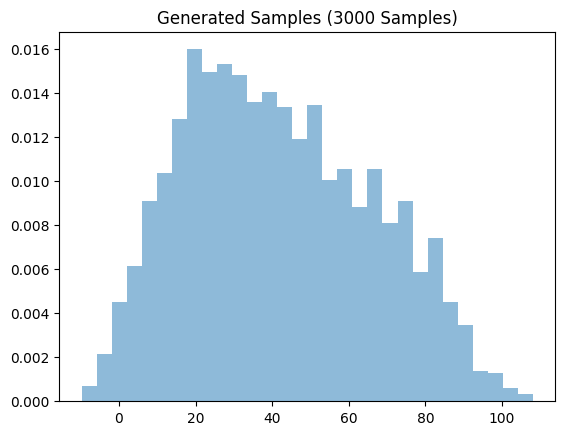

In [90]:
# Generate N samples from the estimated density
N = 3000  # Number of samples to generate
new_samples_R = kde_R.resample(N)

# Visualize the generated samples
plt.hist(new_samples_R.T, bins=30, alpha=0.5, density=True)
plt.title(f"Generated Samples ({N} Samples)")
plt.show()

### A NCBS

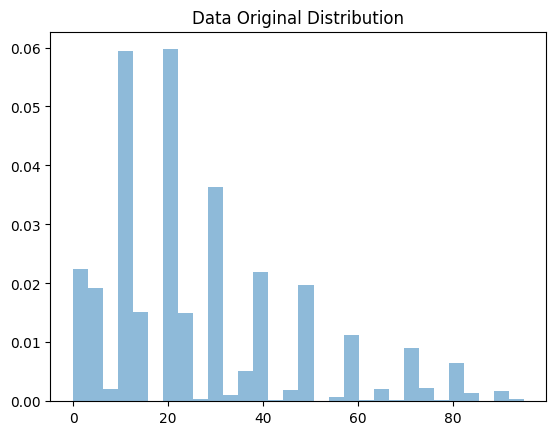

In [91]:
A = NCBS["A"]

plt.hist(A, bins=30, alpha=0.5, density=True)
plt.title("Data Original Distribution")
plt.show()

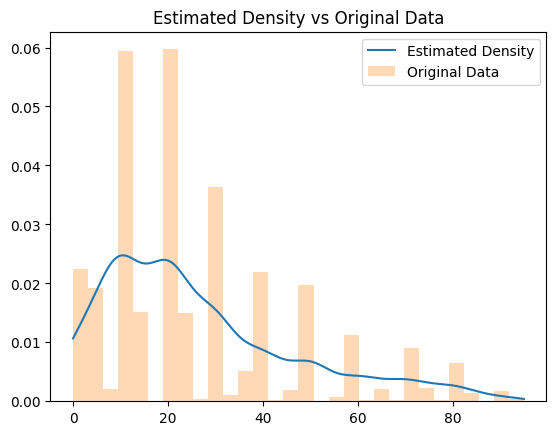

In [92]:
# Estimate density with KDE using Gaussian kernel
kde_A = gaussian_kde(A, bw_method='scott')

# Visualize the estimated density
x_A_vals = np.linspace(min(A), max(A), 3000)
density_A_vals = kde_A(x_A_vals)

plt.plot(x_A_vals, density_A_vals, label='Estimated Density')
plt.hist(A, bins=30, alpha=0.3, density=True, label='Original Data')
plt.title("Estimated Density vs Original Data")
plt.legend()
plt.show()

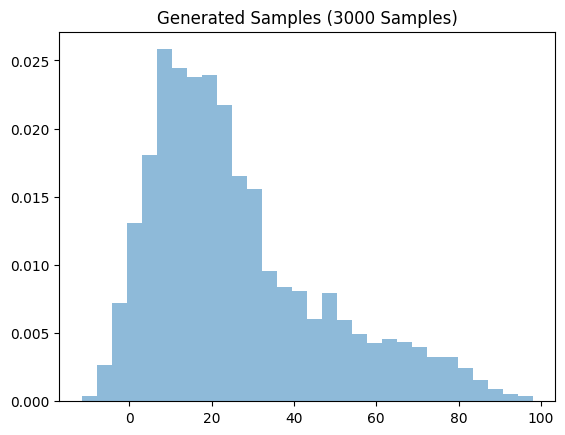

In [93]:
# Generate N samples from the estimated density
N = 3000  # Number of samples to generate
new_samples_A = kde_A.resample(N)

# Visualize the generated samples
plt.hist(new_samples_A.T, bins=30, alpha=0.5, density=True)
plt.title(f"Generated Samples ({N} Samples)")
plt.show()

# Model for Velocity: V,R,A Independents


In [94]:
new_samples_V = np.ravel(new_samples_V) 
new_samples_R = np.ravel(new_samples_R) 
new_samples_A = np.ravel(new_samples_A) 

In [95]:
sample_size = 3000
XX_new = np.column_stack([new_samples_V, new_samples_R, new_samples_A])
XX_new


array([[ 63.39174309, 108.05135193,  10.02036105],
       [ 32.36647904,  43.2933192 ,   6.70618603],
       [ 17.24312022,   5.64641286,  26.70098502],
       ...,
       [ 50.28958231,  39.65290741,  32.83130033],
       [ 63.84251195,  37.35865499,  -4.31439196],
       [ 28.69835323,  57.63440795,  40.56416911]])

In [96]:
df_X_new = pd.DataFrame(XX_new, columns=['x_V', 'x_R', 'x_A'])
XX_new = df_X_new
XX_new

,x_V,x_R,x_A
0,63.391743,108.051352,10.020361
1,32.366479,43.293319,6.706186
2,17.243120,5.646413,26.700985
3,52.020564,9.666768,28.275026
4,23.664739,29.284663,59.204655
...,...,...,...
2995,5.034678,29.610911,37.680471
2996,17.475749,29.085770,33.798838
2997,50.289582,39.652907,32.831300
2998,63.842512,37.358655,-4.314392


In [97]:
XX_new_scaled = scaler.transform(XX_new)
XX_new_scaled

array([[ 1.17987444,  3.79394615, -0.53947997],
       [-0.18360804,  0.34691317, -0.67364971],
       [-0.8482417 , -1.65701009,  0.13581175],
       ...,
       [ 0.60406736,  0.15313613,  0.38398899],
       [ 1.1996846 ,  0.03101439, -1.11980239],
       [-0.34481296,  1.1102811 ,  0.69704336]])

### Applying the model on the NCBS data

In [98]:
Vmoy_predictions =  models["Linear Regression"].predict(XX_new_scaled)

Y_final = pd.DataFrame(Vmoy_predictions, columns=['Vmoy'])
Y_final

,Vmoy
0,44.254126
1,22.826592
2,24.350509
3,28.702070
4,51.534249
...,...
2995,36.856886
2996,35.093168
2997,39.466066
2998,16.378865


In [99]:
Y_final.mean()

Vmoy    34.6596
dtype: float64

In [100]:
np.mean(Y_final)-ot.Normal().computeQuantile(0.95)[0]/np.sqrt(len(Y_final))*np.std(Y_final),\
np.mean(Y_final)+ot.Normal().computeQuantile(0.95)[0]/np.sqrt(len(Y_final))*np.std(Y_final)

(Vmoy    34.214262
 dtype: float64,
 Vmoy    35.104939
 dtype: float64)

### Confidence Interval and S-Curve

Confidence Intervals for Vmoy:
1th Percentile: 8.29 to 9.98
25th Percentile: 23.54 to 24.69
50th Percentile: 31.63 to 33.00
75th Percentile: 41.84 to 43.70
95th Percentile: 62.48 to 65.58
99th Percentile: 73.62 to 76.10


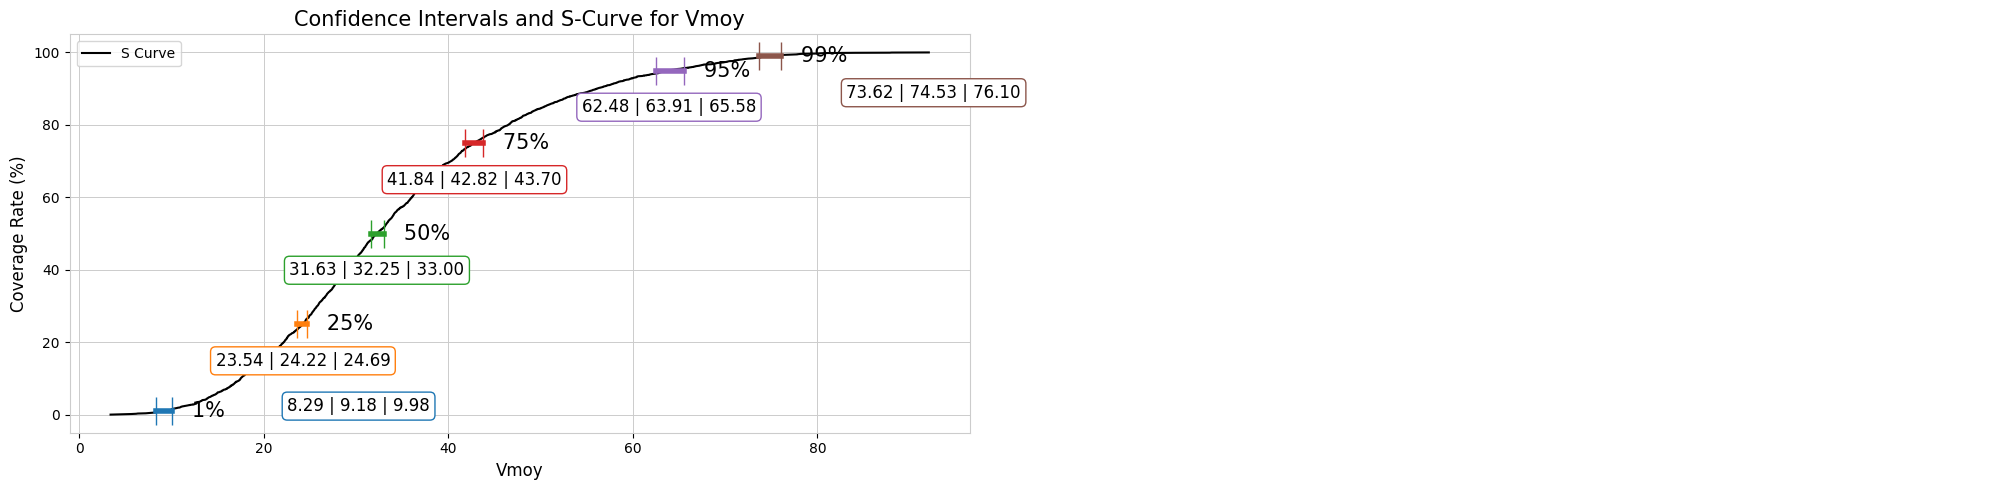

In [117]:
# Simplified functions
def calculate_cdf(data):
    sorted_data = np.sort(data)
    return sorted_data, [percentileofscore(sorted_data, value) for value in sorted_data]

def bootstrap_confidence_interval(data, percentiles=(1, 25, 50, 75, 95, 99), confidence=0.95, n_bootstraps=1000):
    bootstraps = [np.percentile(np.random.choice(data, size=len(data), replace=True), percentiles) for _ in range(n_bootstraps)]
    return {p: (np.percentile(bootstraps, (1-confidence)/2*100, axis=0)[i], 
                np.percentile(bootstraps, (1+confidence)/2*100, axis=0)[i]) for i, p in enumerate(percentiles)}

def plot_confidence_intervals(df, column=None, percentiles=[1, 25, 50, 75, 95, 99], confidence=0.95, n_bootstraps=1000):
    if column:
        # Plot for a single column
        columns = [column]
    else:
        # Plot for all columns
        columns = df.columns
    
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axs = axs.flatten()

    for i, col in enumerate(columns):
        data = df[col].dropna()  # Ensure data does not have NaN values
        sorted_data, cdf = calculate_cdf(data)
        intervals = bootstrap_confidence_interval(data, percentiles, confidence, n_bootstraps)
        
        # Print confidence intervals
        print(f"Confidence Intervals for {col}:")
        for p in percentiles:
            interval = intervals[p]
            print(f"{p}th Percentile: {interval[0]:.2f} to {interval[1]:.2f}")
        
        ax = axs[i]
        
        # S-curve plot
        ax.plot(sorted_data, cdf, color='k', label='S Curve')
        
        # Confidence intervals and percentiles
        for j, p in enumerate(percentiles):
            interval = intervals[p]
            percentile_value = np.percentile(data, p)
            ax.plot(interval, [p, p], '|-', markersize=20, color=f'C{j}', linewidth=4)

            # Determine position of the annotation text
            if p == 1:
                xytext = (140, 0)  # Higher offset for low percentiles
            elif p == 99:
                xytext = (120, -30)  # Lower offset for high percentiles
            else:
                xytext = (0, -30)  # Default offset for other percentiles

            ax.text(interval[1], p, f'   {p}% ', fontsize=15, verticalalignment='center')
            ax.annotate(f'{interval[0]:.2f} | {percentile_value:.2f} | {interval[1]:.2f}', 
                        (percentile_value, p), textcoords="offset points", xytext=xytext, ha='center', 
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor=f'C{j}', facecolor="white"))

        # Axis limits, labels, and titles
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Coverage Rate (%)', fontsize=12)
        ax.set_title(f'Confidence Intervals and S-Curve for {col}', fontsize=15)
        ax.legend(loc='best', fontsize=10)

        # Set grid and axis line color
        grid_color = '.8'
        ax.grid(True, color=grid_color, linestyle='-', linewidth=0.7)
        ax.spines['bottom'].set_color(grid_color)
        ax.spines['top'].set_color(grid_color)
        ax.spines['right'].set_color(grid_color)
        ax.spines['left'].set_color(grid_color)
        ax.tick_params(axis='both', colors='black', labelsize=10)

    # Turn off unused subplots
    for i in range(len(columns), len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot for a single column
plot_confidence_intervals(Y_final, 'Vmoy', percentiles=[1, 25, 50, 75, 95, 99])


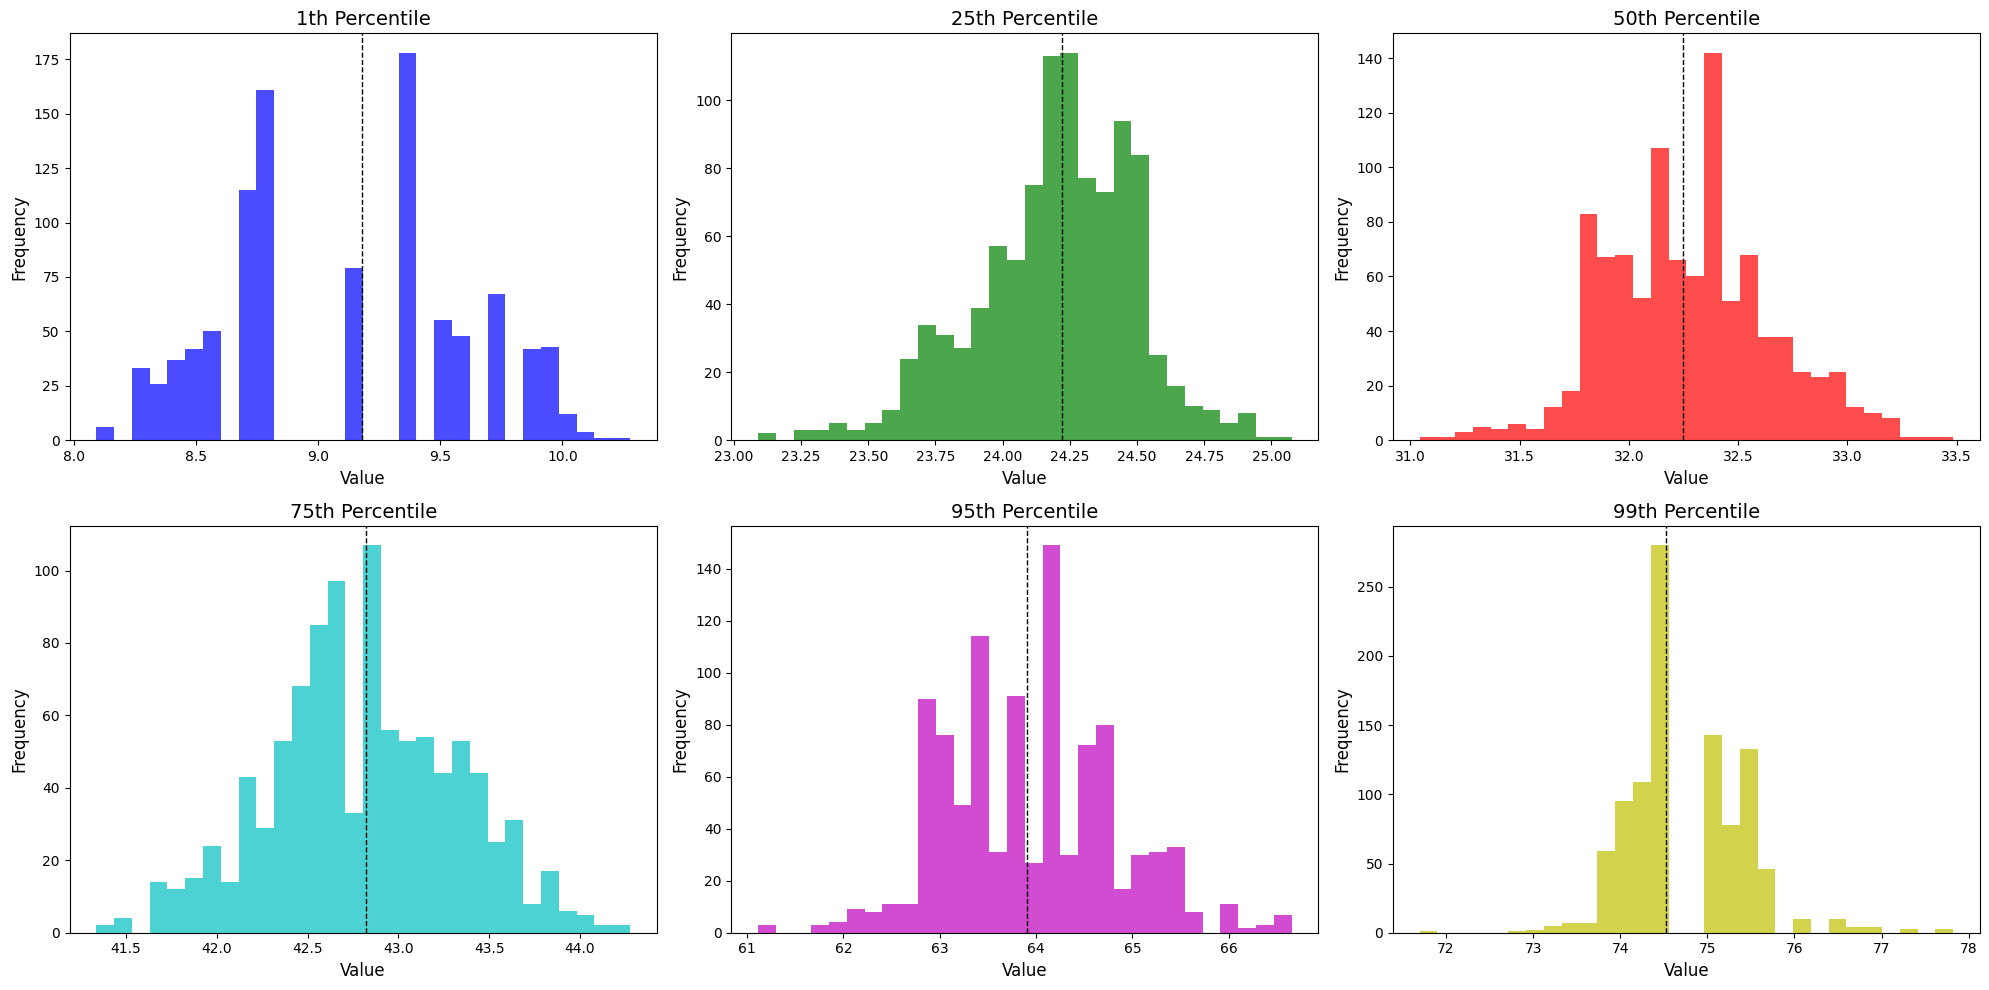

In [113]:

def plot_bootstrap_distributions(df, column, percentiles=[1, 25, 50, 75, 95, 99], confidence=0.95, n_bootstraps=1000, colors=['b', 'g', 'r', 'c', 'm', 'y']):
    # Filter the data for the specific column
    data = df[column]

    # Generate bootstrap samples and calculate percentiles for each bootstrap
    bootstrapped_percentiles = {p: [] for p in percentiles}
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        for p in percentiles:
            bootstrapped_percentiles[p].append(np.percentile(bootstrap_sample, p))

    # Determine the number of rows and columns needed for the subplots
    n_cols = 3
    n_rows = (len(percentiles) + n_cols - 1) // n_cols

    # Plot the distributions of the bootstrap percentiles
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

    for i, p in enumerate(percentiles):
        ax = axs[i]
        # Plot histogram of the bootstrap percentiles
        ax.hist(bootstrapped_percentiles[p], bins=30, color=colors[i % len(colors)], alpha=0.7)
        # Add a vertical line for the actual percentile value from the original data
        ax.axvline(np.percentile(data, p), color='k', linestyle='dashed', linewidth=1)
        ax.set_title(f'{p}th Percentile', fontsize=14)
        ax.set_xlabel('Value', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

        # Remove grid lines
        ax.grid(False)

    # Turn off unused subplots if there are any
    for i in range(len(percentiles), len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
plot_bootstrap_distributions(Y_final, 'Vmoy', percentiles=[1, 25, 50, 75, 95, 99])
